In [ ]:
# pip install factor_analyzer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [120]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [38]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Split data into 80% training, 20% test
train, test = train_test_split(df, test_size=0.2)

# Create dataframe of factors only
df_fct =  train.drop(['UID','Const'], axis=1)

## Exploratory Data Analysis
**Pandas-Profiling:** Used to create a full report of distributions for each variable as well as correlations.

Note: The HTML report file should be opened in your browser (not JupyterLab), and it takes a couple of minutes to load all of the correlation information.

**Correlation Plot:** Seaborn plot of Pearson correlations between factor variables.

There is clearly an increased correlation between variables in groups of 6.

In [39]:
# Create pandas-profiling report
profile = ProfileReport(df_fct, title="Pandas Profiling Report")
profile.to_file("profiling_report.html")

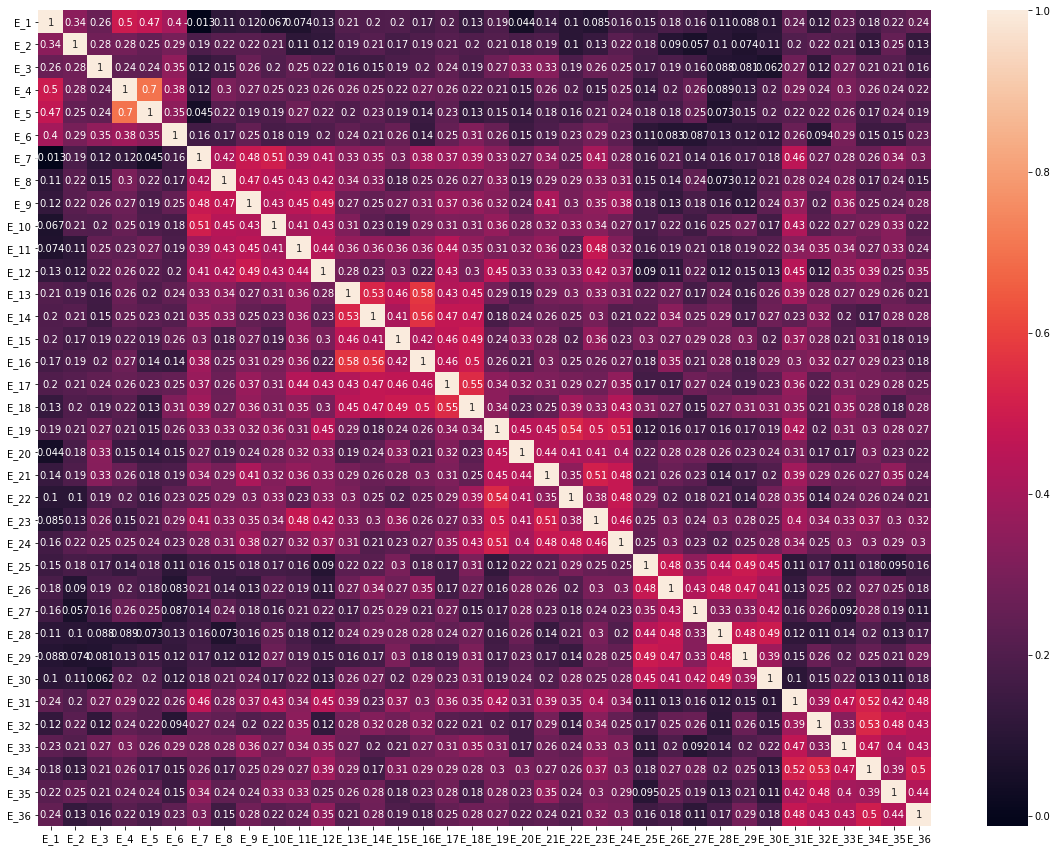

In [40]:
# Visually inspect for any strong correlations between variables
corrMatrix = df_fct.corr()

fig, ax = plt.subplots(figsize=(20,15))  # There are a lot of factors, so I made the figure large enough to see each of them

sn.heatmap(corrMatrix, annot=True)
plt.show()

## Factor Analysis

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

Note: I think a varimax rotation might be good here because it will create more sparsity in the columns and help identify latent factors.  We can see in the correlation plot above that some variables are more similar than others, and a varimax rotation will help tease that out.

### 5 Factors, Quartimax Rotation
In the heatmap below, Factor 1 clearly explains the most variance.  The other four factors have clearly defined areas of explained variance.

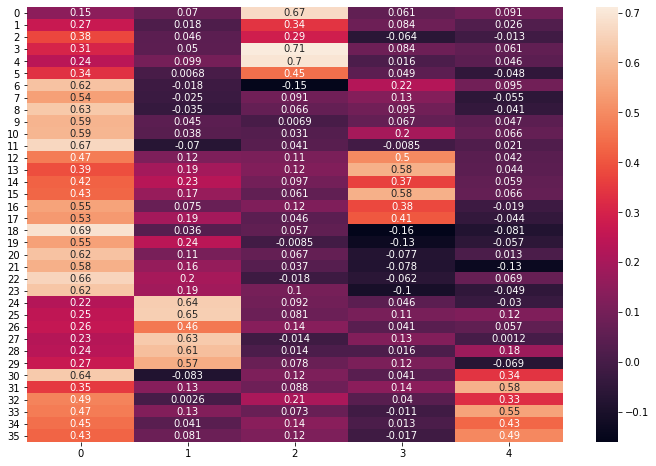

In [70]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=5, rotation='quartimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

### 5 Factors, Varimax Rotation
I decided to try a varimax rotation to create sparsity in the loadings and amplify those clearly defined areas of variance explanation.  The increase in loading values is not profound, but you can see that the clearly defined areas of Factors 2-5 have fewer dark orange/red cells, meaning the rotation increased the amount of variance explained by that particular factor.

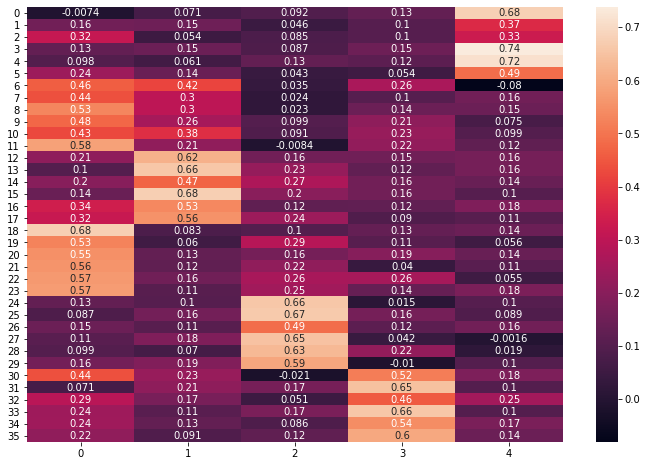

In [74]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=5, rotation='varimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

### 6 Factors, Varimax Rotation
Because the correlation matrix of the original data suggested that there are 6 major areas of correlation within the original dataset, I tried 6 factors and a varimax rotation.  As expected, 6 distinct areas of variance explanation emerged across the factors.  

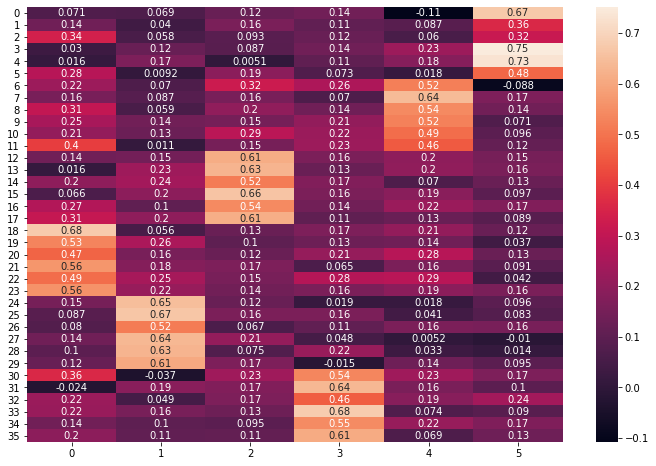

In [114]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=6, rotation='varimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

In [84]:
# ev, v = fa.get_eigenvalues()

array([10.39884088,  2.50580935,  2.16116051,  1.75353888,  1.68636087,
        1.30945212])

In [115]:
# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,7),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:6],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:6],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

cov_matrix_eigenvals

,eigenvalues,common_factor_eigenvalues,variance,proportional_variance,cumulative_variance
factor,,,,,
1,10.398841,9.872712,3.094870,0.085969,0.085969
2,2.505809,1.971176,2.950930,0.081970,0.167939
3,2.161161,1.680445,2.925348,0.081260,0.249199
4,1.753539,1.249611,2.773488,0.077041,0.326240
5,1.686361,1.162273,2.501668,0.069491,0.395731
6,1.309452,0.785320,2.475233,0.068756,0.464487


The 6 factors identified here account for 46.4% of variance in the original dataset.

In [118]:
scores = fa.transform(df_fct)

In [119]:
scores

array([[-0.18800357, -0.49784399,  0.55586063,  0.83247352, -1.15357772,
         0.09397201],
       [ 0.20546323,  1.1492369 ,  0.06146991, -0.11716305, -0.73049023,
         0.34024715],
       [-0.6880694 , -0.20968299,  1.79651224,  1.02748728,  0.53941728,
         0.05930163],
       ...,
       [ 0.05898732, -0.64705506,  0.34663387,  0.78654199, -1.26190649,
         0.77674915],
       [-2.03636096,  1.8780561 ,  1.17757787, -3.15395472, -0.33662631,
        -1.3287142 ],
       [ 0.08473747,  0.43543751,  0.23490884, -0.41420102,  0.70504661,
         0.05918079]])

## k-Means Clustering
The original variables separated into 6 factors very nicely, so I used six.

In [121]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [123]:
kmeans.labels_

array([2, 1, 2, 3, 3, 3, 3, 2, 3, 5, 2, 3, 0, 4, 3, 0, 2, 2, 2, 3, 1, 2,
       1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 0, 4, 1, 1,
       2, 2, 1, 2, 2, 0, 4, 2, 2, 2, 1, 1, 1, 4, 2, 2, 2, 2, 2, 2, 2, 4,
       0, 4, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 3, 2, 5, 1,
       1, 2, 1, 0, 1, 2, 1, 0, 5, 0, 1, 1, 5, 3, 1, 2, 2, 1, 4, 4, 3, 4,
       1, 1, 2, 3, 0, 2, 2, 1, 0, 1, 0, 2, 2, 3, 0, 4, 4, 3, 1, 1, 0, 2,
       5, 1, 3, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 2, 3, 3, 2, 4, 1, 2,
       2, 0, 2, 2, 2, 3, 2, 3, 1, 1, 1, 2, 1, 3, 2, 2, 2, 1, 1, 2, 3, 5,
       1, 1, 2, 2, 1, 2, 2, 2, 5, 1, 4, 3, 4, 2, 2, 5, 5, 2, 2, 1, 3, 1,
       2, 2, 3, 1, 2, 4, 2, 4, 4, 1, 2, 3, 5, 4, 2, 4, 2, 0, 3, 1, 2, 0,
       2, 2, 2, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 3, 1, 3, 4, 1, 2, 3, 5, 3,
       3, 2, 2, 2, 3, 2, 0, 1, 1, 0, 2, 3, 3, 3, 1, 1, 2, 0, 2, 1, 1, 3,
       2, 2, 2, 2, 4, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2,
       1, 5, 1, 4, 3, 1, 1, 4, 3, 1, 0, 2, 2, 0, 1,

In [ ]:
train['cluster'] = kmeans.labels_

In [130]:
train['cluster'].value_counts()

2    133
1     82
3     43
0     35
4     31
5     15
Name: cluster, dtype: int64

In [140]:
# Create elbow plot for k-means clustering
# This plot doesn't show much of an elbow, just a gentle curve.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scores)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
xvals = range(1, df_fct.shape[1]+1)

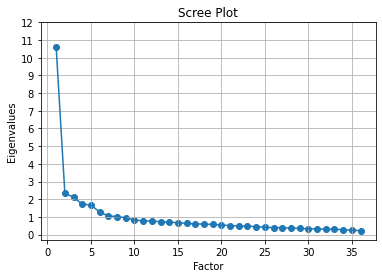

In [20]:
# Create scree plot
plt.scatter(xvals,ev)
plt.plot(xvals, ev)
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalues')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.show()

In [16]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [17]:
v

array([ 1.00384127e+01,  1.76655893e+00,  1.57385891e+00,  1.18512982e+00,
        1.13391096e+00,  6.96962949e-01,  4.64937967e-01,  4.23663399e-01,
        3.47115063e-01,  2.29655462e-01,  2.05732370e-01,  2.01155005e-01,
        1.37720907e-01,  1.27301511e-01,  9.46998026e-02,  8.27808421e-02,
        6.90442002e-02,  1.09338178e-02,  4.89412079e-03, -1.63612698e-02,
       -4.27394901e-02, -8.11548252e-02, -8.92359590e-02, -1.13228783e-01,
       -1.34440020e-01, -1.47318115e-01, -1.74436124e-01, -1.84286635e-01,
       -2.04186908e-01, -2.15724482e-01, -2.39301301e-01, -2.59729230e-01,
       -2.80931631e-01, -2.82997622e-01, -3.07658120e-01, -3.22865387e-01])

In [12]:
eigen=pd.DataFrame(v,columns=['eigenvalues']) 


In [13]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [14]:
num_of_facts=sum(i >= 1 for i in ev)

In [15]:
fa = FactorAnalyzer(n_factors=num_of_facts,rotation='quartimax')

In [16]:
fa.fit(df_fct)

FactorAnalyzer(n_factors=8, rotation='quartimax', rotation_kwargs={})

In [17]:
loadings = fa.loadings_

In [18]:
len(loadings)

36

In [26]:
import pandas as pd 
factor_scores = fa.transform(df_fct)
factor_scores = pd.DataFrame(factor_scores)
loadings = pd.DataFrame(loadings)
factor_scores.to_excel('C:/kmeans/factor_scores.xlsx')
loadings.to_excel('C:/kmeans/loadings.xlsx')


In [49]:
loadings_abs=loadings.abs()
loadings[loadings.abs() >= .4].count()



0    16
1     6
2     3
3     6
4     6
5     1
6     1
7     0
dtype: int64

Below is for KMEANS Clustering

In [38]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import numpy as np

In [55]:
X=df_fct
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)

In [57]:
plt.scatter(X[:,0],X[:,36], c=kmeans.labels_, cmap='rainbow')

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [56]:
clusters

array([0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0,
       1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2,
       0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0,

In [59]:
mglearn.plots.plot_dbscan()

NameError: name 'mglearn' is not defined

In [61]:
from sklearn.cluster import DBSCAN

In [1]:
from scipy.stats import pearsonr
import numpy as np


In [2]:
def pearson_affinity(M):
   return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])